<a href="https://colab.research.google.com/github/Chuchu-Wan/ANNs-Real-World-Implementation-Neural-Networks-for-Predicting-Population-Mobility-in-Chinese-Cities/blob/main/FinalProject_Timesheries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

file_path = '/content/drive/My Drive/NNs/maindata_clean.dta'

data = pd.read_stata(file_path)
print("Data Overview:")
print(data.head())

Data Overview:
     year    Cityid  地区     地区生产总值万元   第一产业增加值万元    第二产业增加值万元     第三产业增加值万元  \
0  2009.0  110000.0  北京  121530000.0  1178841.00  28559550.00  9.179161e+07   
1  2010.0  110000.0  北京  141135800.0  1241995.04  33886705.58  1.060071e+08   
2  2011.0  110000.0  北京  162519300.0  1365162.12  37525706.37  1.236284e+08   
3  2012.0  110000.0  北京  178794000.0  1501869.60  40586238.00  1.367059e+08   
4  2013.0  110000.0  北京  195005600.0  1618546.48  43525249.92  1.498618e+08   

   第一产业增加值占GDP比重  第二产业增加值占GDP比重  第三产业增加值占GDP比重  ...  Population_density  \
0           0.97          23.50          75.53  ...              759.14   
1           0.88          24.01          75.11  ...              766.44   
2           0.84          23.09          76.07  ...              778.70   
3           0.84          22.70          76.46  ...              790.60   
4           0.83          22.32          76.85  ...              802.11   

   Popjuniorcollege  Popcollege  Human_capital_index  GDP_1

In [ ]:
from sklearn.impute import KNNImputer

data.drop(columns=['地区', 'Cityid'], inplace=True, errors='ignore')

target = 'Population_mobility_rate'
features = [col for col in data.columns if col != target]

X = data[features]
y = data[target]

X = X.apply(pd.to_numeric, errors='coerce')

print(f"X shape: {X.shape}, features count: {len(features)}")

if X.shape[1] != len(features):
    print("列数不匹配，调整 features 列表！")
    features = X.columns.tolist()

imputer = KNNImputer(n_neighbors=5)
X_filled = imputer.fit_transform(X)

if X_filled.shape[1] != len(features):
    print(f"填补后列数与 features 不符：{X_filled.shape[1]} vs {len(features)}")
    features = [f"Feature_{i}" for i in range(X_filled.shape[1])]

X_filled_df = pd.DataFrame(X_filled, columns=features)

print("填补后的数据（前5行）:")
print(X_filled_df.head())

if y.isnull().sum() > 0:
    y_filled = y.fillna(y.mean())
else:
    y_filled = y

X shape: (3372, 196), features count: 196
填补后列数与 features 不符：179 vs 196
填补后的数据（前5行）:
   Feature_0    Feature_1   Feature_2    Feature_3     Feature_4  Feature_5  \
0     2009.0  121530000.0  1178841.00  28559550.00  9.179161e+07       0.97   
1     2010.0  141135800.0  1241995.04  33886705.58  1.060071e+08       0.88   
2     2011.0  162519300.0  1365162.12  37525706.37  1.236284e+08       0.84   
3     2012.0  178794000.0  1501869.60  40586238.00  1.367059e+08       0.84   
4     2013.0  195005600.0  1618546.48  43525249.92  1.498618e+08       0.83   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_169  Feature_170  \
0      23.50      75.53    70452.0    1245.83  ...      38765.6       759.14   
1      24.01      75.11    75943.0    1257.80  ...      51048.4       766.44   
2      23.09      76.07    81658.0    1277.90  ...      52920.0       778.70   
3      22.70      76.46    87475.0    1297.50  ...      52920.0       790.60   
4      22.32      76.85    93213.0    13

In [ ]:
missing_columns = set(features) - set(X_filled_df.columns)
print("被删除的特征列:", missing_columns)

被删除的特征列: set()


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filled_df)

print("标准化后的特征形状:", X_scaled.shape)

标准化后的特征形状: (3372, 179)


In [ ]:
def create_time_series(X, y, time_steps):
    X_series, y_series = [], []
    for i in range(len(X) - time_steps):
        X_series.append(X[i:i + time_steps])
        y_series.append(y[i + time_steps])
    return np.array(X_series), np.array(y_series)

time_steps = 10
X_series, y_series = create_time_series(X_scaled, y, time_steps)

print("时间序列数据形状:", X_series.shape, y_series.shape)

时间序列数据形状: (3362, 10, 179) (3362,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, random_state=42)

print("训练集和测试集大小:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

训练集和测试集大小:
X_train: (2689, 10, 179) y_train: (2689,)
X_test: (673, 10, 179) y_test: (673,)


In [ ]:
print("检查数据中是否存在 NaN 或 Inf：")
print("NaN in X_train:", np.isnan(X_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

检查数据中是否存在 NaN 或 Inf：
NaN in X_train: 0
Inf in X_train: 0
NaN in y_train: 675
Inf in y_train: 0


In [ ]:
pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=b83deba3814691f9e2c6dac4236bf8f57839fd01aac9107c151b9d36ab095438
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=f94624df781f6dc5f1001edda588ea34a34162128826a4fc5e4124b648694454
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
from fancyimpute import KNN

y_train = y_train.reshape(-1, 1)
y_train = KNN(k=3).fit_transform(y_train).flatten()
print("NaN in y_train after KNN filling:", np.isnan(y_train).sum())

Imputing row 1/2689 with 0 missing, elapsed time: 0.801
Imputing row 101/2689 with 0 missing, elapsed time: 0.802
Imputing row 201/2689 with 0 missing, elapsed time: 0.802
Imputing row 301/2689 with 0 missing, elapsed time: 0.803
Imputing row 401/2689 with 0 missing, elapsed time: 0.804
Imputing row 501/2689 with 0 missing, elapsed time: 0.804
Imputing row 601/2689 with 1 missing, elapsed time: 0.808
Imputing row 701/2689 with 0 missing, elapsed time: 0.810
Imputing row 801/2689 with 0 missing, elapsed time: 0.811
Imputing row 901/2689 with 1 missing, elapsed time: 0.812
Imputing row 1001/2689 with 0 missing, elapsed time: 0.814
Imputing row 1101/2689 with 0 missing, elapsed time: 0.815
Imputing row 1201/2689 with 0 missing, elapsed time: 0.816
Imputing row 1301/2689 with 0 missing, elapsed time: 0.818
Imputing row 1401/2689 with 0 missing, elapsed time: 0.819
Imputing row 1501/2689 with 0 missing, elapsed time: 0.820
Imputing row 1601/2689 with 0 missing, elapsed time: 0.821
Imputing 

In [ ]:
print("NaN in y_train after processing:", np.isnan(y_train).sum())


NaN in y_train after processing: 0


In [ ]:
import numpy as np

print("NaN in y_test:", np.isnan(y_test).sum())
print("Inf in y_test:", np.isinf(y_test).sum())

y_test = np.nan_to_num(y_test, nan=np.nanmean(y_test))
print("NaN in y_test after filling:", np.isnan(y_test).sum())

NaN in y_test: 177
Inf in y_test: 0
NaN in y_test after filling: 0


In [ ]:
def augment_data(X, y, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, X.shape)
    X_noisy = X + noise
    return np.concatenate([X, X_noisy]), np.concatenate([y, y])

X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(time_steps, X_train.shape[2])),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.4985 - mae: 0.1382 - val_loss: 0.2050 - val_mae: 0.1154
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1834 - mae: 0.1286 - val_loss: 0.0866 - val_mae: 0.1078
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0951 - mae: 0.1124 - val_loss: 0.0756 - val_mae: 0.1087
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0937 - mae: 0.1233 - val_loss: 0.0652 - val_mae: 0.1100
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1003 - mae: 0.1251 - val_loss: 0.0600 - val_mae: 0.1112
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0658 - mae: 0.1096 - val_loss: 0.0486 - val_mae: 0.0959
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0535 - mae: 0.1022 - val_loss: 0.0757 - val_mae: 0.1118
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0670 - mae: 0.1093 - val_loss: 0.0501 - val_mae: 0.1155
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/

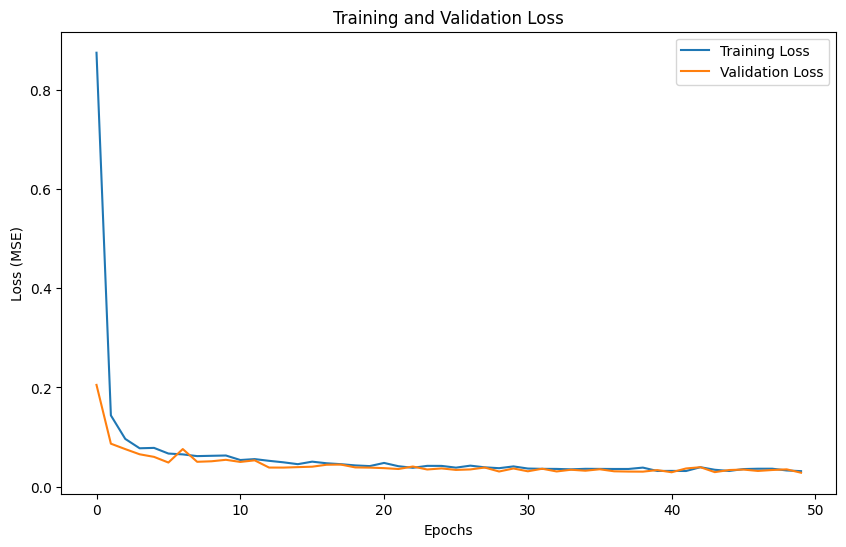

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

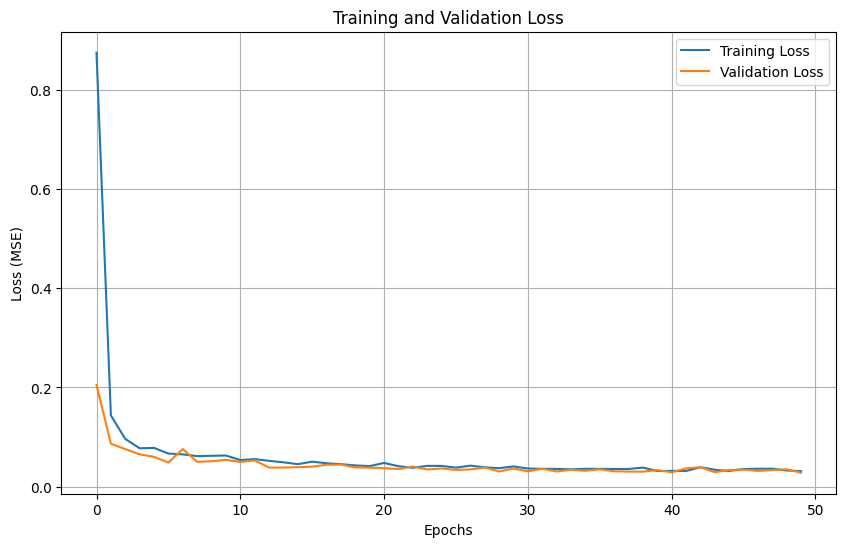

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"测试集 MSE: {mse}, MAE: {mae}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
测试集 MSE: 0.02922076848850319, MAE: 0.08692132448607297


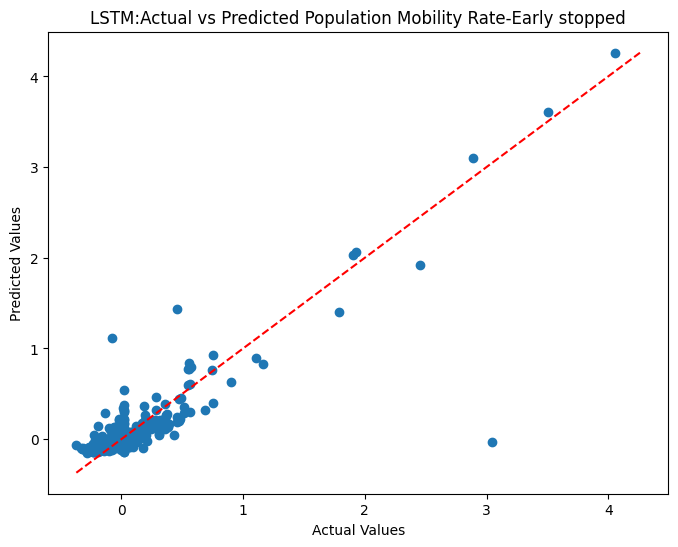

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
# Add a diagonal line
diagonal = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(diagonal, diagonal, color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LSTM:Actual vs Predicted Population Mobility Rate-Early stopped')
plt.show()